In [1]:
import logging
logging.basicConfig(filename="logs.log", level=logging.INFO)
from tqdm import tqdm
from ENPMDA import MDDataFrame

In [2]:
from msm_a7_nachrs.tica.tica import TICAInitializer, SymTICAInitializer
from msm_a7_nachrs.manuscript.manuscript import *

<Figure size 432x288 with 0 Axes>

In [3]:
from msm_a7_nachrs.util.plotly_fes import generate_tica_csv, export_plotly, export_plotly_3d

In [4]:
import numpy as np
import pyemma
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import ticker

import itertools

from scipy.signal import convolve2d
from scipy.ndimage import maximum_filter

## Construct TICA

In [5]:
md_dataframe = MDDataFrame.load_dataframe('./a7_apos_feature/a7_apos_feature_md_dataframe')

In [6]:
if False:
    # repeat five times
    pair_indices_union_df_2diff = pd.read_pickle('pair_indices_union_df_2div.pickle')
    min_arr = np.concatenate([pair_indices_union_df_2diff.distance_min.values]*5)
    max_arr = np.concatenate([pair_indices_union_df_2diff.distance_max.values]*5)
    md_dataframe.transform_to_logistic_with_minmax(feature_name='ca_distance_10A_2diff',
                                                logistic=2,
                                                min_arr=min_arr,
                                                max_arr=max_arr)

In [7]:
# lag time = lag time * dt ns
updating = False
lag=50
start=100
msm_obj = SymTICAInitializer(
                         md_dataframe=md_dataframe,
                         lag=lag,
                         start=start,
                         end=-1,
                         system_exclusion=[],
                         updating=updating,
                         in_memory=False
                         )

lag time is 50.0 ns
start time is 100.0 ns


In [8]:
start_seed_index = md_dataframe.dataframe[    
    (md_dataframe.dataframe.seed == 0) & 
    (md_dataframe.dataframe.frame == 0) &
    (md_dataframe.dataframe.ensemble == 'PRODUCTION')].system.unique()

In [9]:
start_seed_pathways = md_dataframe.dataframe[    
    (md_dataframe.dataframe.seed == 0) & 
    (md_dataframe.dataframe.frame == 0) &
    (md_dataframe.dataframe.ensemble == 'PRODUCTION')].pathway.unique()

start_seed_strucs = [pathway.split('_')[0] for pathway in start_seed_pathways]

In [10]:
start_seed_index, start_seed_strucs

(array([0, 24, 48, 73, 97, 121], dtype=object),
 ['BGT', 'BGT', 'EPJPNU', 'EPJPNU', 'EPJ', 'EPJ'])

In [11]:
feat_info = md_dataframe.get_feature_info('ca_distance_10A_2diff')
#resids_exclusion = list(range(292, 402)) + list(range(1,25)) + list(range(60, 75))
#resids_exclusion = list(range(280, 402)) + list(range(1,25)) + list(range(60, 75))
resids_exclusion = list(range(386, 397)) + list(range(298, 364)) + list(range(1,25)) + list(range(60, 75))
feat_ind_exclusion = []
feat_ind_inclusion = []
for ind, feat in enumerate(feat_info):
    resid1 = eval(feat.split('_')[1])
    resid2 = eval(feat.split('_')[3])
    if resid1 in resids_exclusion or resid2 in resids_exclusion:
        feat_ind_exclusion.append(ind)
    else:
        feat_ind_inclusion.append(ind)

In [12]:
#msm_obj_tica.add_feature('pore_hydration', feat_type='global')
msm_obj.add_feature('ca_distance_10A_2diff_reciprocal',
                    excluded_indices=feat_ind_exclusion,
                    feat_type='subunit')

msm_obj.start_analysis()
tica_concatenated = msm_obj.tica_concatenated
tica_output = msm_obj.tica_output
tica_subunit_output = msm_obj.tica_subunit_output
tica_subunit_concatenated = msm_obj.tica_subunit_concatenated
#msm_obj.feature_trajectories = msm_obj.feature_trajectories[::5]
print(tica_concatenated.shape)

added feature selection ca_distance_10A_2diff_reciprocal type: subunit, # of features: 2795
Load old sym TICA results
(199763, 110)


In [13]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1,context='poster')
sns.set_context({"figure.figsize": (12, 12)})

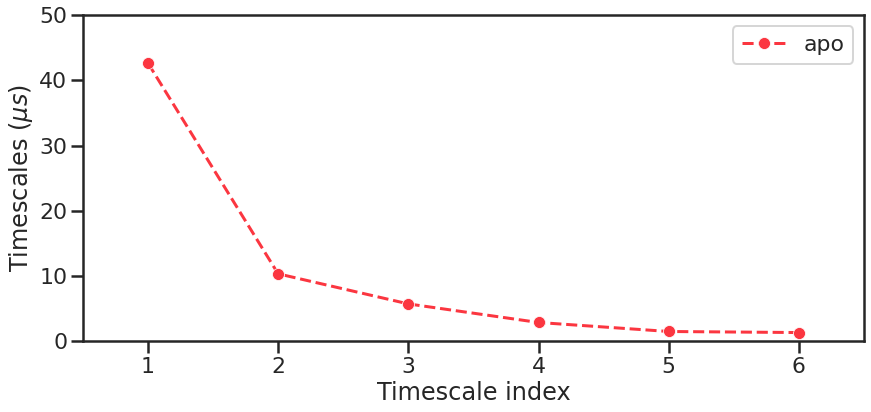

In [14]:
tica_model_tica = msm_obj.tica.fetch_model()
fig, ax = plt.subplots(figsize=(14,6))
n_timescales=6
tic_series = np.arange(1, n_timescales+1)
time_series = tica_model_tica.timescales(k=n_timescales) * msm_obj.dt / 1000
sns.lineplot(x=tic_series,
             y=time_series,
             marker='o', linestyle='--',
             color=system_color_dict['apo'], label='apo')
#for tic, time in zip(tic_series, time_series):
#    ax.text(x=tic + 0.1, y=time + 1.2, s='{:0.1f}'.format(time), fontsize=16)
ax.set_ylabel(r'Timescales ($\mu s$)')
ax.set_xlabel('Timescale index')
ax.set_ylim(0,50)
ax.set_xlim(0.5,n_timescales+0.5)
ax.set_xticks(tic_series)
plt.savefig('assets/apo/timescales_symtica_allfeat.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

## Load other dataframe

In [15]:
md_7ekt_dataframe = MDDataFrame.load_dataframe('./7ekt_feature/7ekt_feature_md_dataframe')
md_7ekt_dataframe.transform_to_logistic('ca_distance_10A_2diff', logistic=5)
md_7ekt_dataframe.transform_to_reciprocal('ca_distance_10A_2diff')
pair_indices_union_df_2diff = pd.read_pickle('pair_indices_union_df_2div.pickle')
min_arr = np.concatenate([pair_indices_union_df_2diff.distance_min.values]*5)
max_arr = np.concatenate([pair_indices_union_df_2diff.distance_max.values]*5)
md_7ekt_dataframe.transform_to_logistic_with_minmax(feature_name='ca_distance_10A_2diff',
                                            logistic=5,
                                            min_arr=min_arr,
                                            max_arr=max_arr)
tica_output_7ekt = msm_obj.transform_feature_trajectories(md_7ekt_dataframe,
                                                          symmetrized=False)
tica_output_subunit_7ekt = msm_obj.transform_feature_trajectories(md_7ekt_dataframe,
                                                                  subunit=True,
                                                                  symmetrized=False)

100%|██████████| 4/4 [00:00<00:00, 212.04it/s]


Finish transforming to logistic.


100%|██████████| 4/4 [00:00<00:00, 228.18it/s]

Finish transforming to reciprocal.



100%|██████████| 4/4 [00:00<00:00, 215.19it/s]

Finish transforming to logistic.



100%|██████████| 4/4 [00:00<00:00, 16.82it/s]


In [16]:
md_df_dataframe = MDDataFrame.load_dataframe('./density_fitting_feature/DENSITY_FITTING_feature_md_dataframe')
md_df_dataframe.transform_to_logistic('ca_distance_10A_2diff', logistic=5)
md_df_dataframe.transform_to_reciprocal('ca_distance_10A_2diff')
md_df_dataframe.transform_to_logistic_with_minmax(feature_name='ca_distance_10A_2diff',
                                            logistic=5,
                                            min_arr=min_arr,
                                            max_arr=max_arr)
tica_output_df = msm_obj.transform_feature_trajectories(md_df_dataframe,
                                                        symmetrized=False)
tica_output_subunit_df = msm_obj.transform_feature_trajectories(md_df_dataframe,
                                                                subunit=True,
                                                                symmetrized=False)

100%|██████████| 2/2 [00:00<00:00, 51.49it/s]


Finish transforming to logistic.


100%|██████████| 2/2 [00:00<00:00, 55.92it/s]

Finish transforming to reciprocal.



100%|██████████| 2/2 [00:00<00:00, 54.55it/s]


Finish transforming to logistic.


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


In [17]:
md_climber_dataframe = MDDataFrame.load_dataframe('./climber_feature/climber_feature_md_dataframe')
md_climber_dataframe.transform_to_logistic('ca_distance_10A_2diff', logistic=5)
md_climber_dataframe.transform_to_reciprocal('ca_distance_10A_2diff')
md_climber_dataframe.transform_to_logistic_with_minmax(feature_name='ca_distance_10A_2diff',
                                            logistic=5,
                                            min_arr=min_arr,
                                            max_arr=max_arr)
md_climber_dataframe.dataframe['pathway'] = md_climber_dataframe.dataframe.traj_name.apply(lambda x: x.split('/')[-3])
tica_output_climber = msm_obj.transform_feature_trajectories(md_climber_dataframe,
                                                                symmetrized=False)
tica_output_subunit_climber = msm_obj.transform_feature_trajectories(md_climber_dataframe,
                                                                        subunit=True,
                                                                        symmetrized=False)

100%|██████████| 6/6 [00:00<00:00, 234.94it/s]


Finish transforming to logistic.


100%|██████████| 6/6 [00:00<00:00, 267.12it/s]

Finish transforming to reciprocal.



100%|██████████| 6/6 [00:00<00:00, 244.88it/s]

Finish transforming to logistic.



100%|██████████| 6/6 [00:00<00:00, 25.66it/s]


## Construct MSM

In [18]:
tica_dens_kwargs = {'logscale': True,
                    'cmap': 'inferno',
                    'ncontours': 30,
                    'avoid_zero_counts': True,
                    'nbins': 80
}

In [20]:
state_tica_coord = {}
for seed, struc in zip(start_seed_index[::2],
                       start_seed_strucs[::2]):
    state_tica_coord[struc_2_state[struc]] = {}
    state_tica_coord[struc_2_state[struc]]['tica']= tica_output[seed][0, :]
    state_tica_coord[struc_2_state[struc]]['tica_subunit'] = tica_subunit_output[seed][0, :, :]

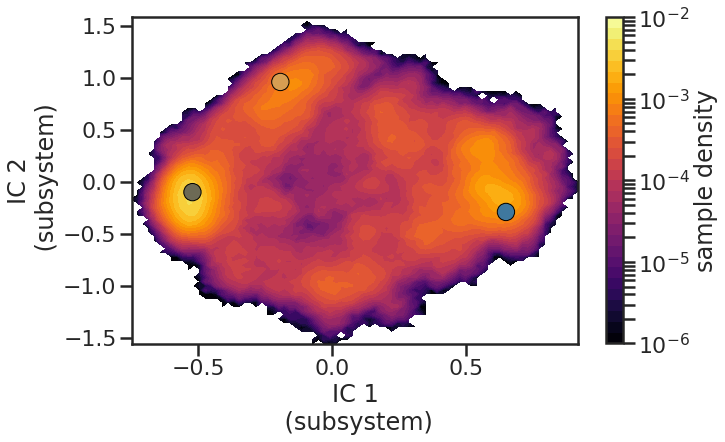

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
tica_subunit_sep_concate = np.concatenate(tica_subunit_concatenated, axis=0)

contourf_kws = dict(locator=ticker.LogLocator(base=10, subs=range(1, 10)))
pyemma.plots.plot_density(
            tica_subunit_sep_concate.T[0],
            tica_subunit_sep_concate.T[1],
            **tica_dens_kwargs,
            ax=ax)

ax.scatter(x=np.mean([state_tica_coord[state]['tica_subunit'][:,0] for state in state_tica_coord], axis=1),
           y=np.mean([state_tica_coord[state]['tica_subunit'][:,1] for state in state_tica_coord], axis=1),
           marker='o', s=300,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='black',
           lw=1)

ax.set_xlabel('IC 1\n (subsystem)')
ax.set_ylabel('IC 2\n (subsystem)')

plt.savefig('assets/apo/tica_subsystem_all.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

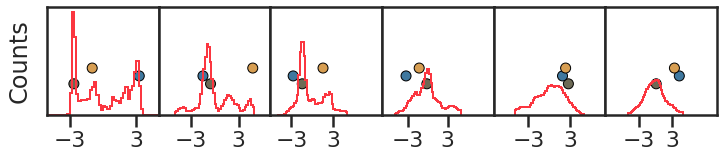

In [28]:
fig, axes = plt.subplots(1, n_timescales, figsize=(2 * n_timescales, 2),
                        sharey=True, gridspec_kw={'wspace': 0.0},
                        subplot_kw={'yticks': []}
                         )
for tic, ax in zip(range(n_timescales), axes):
    ax.hist(tica_concatenated[:, tic].T, bins=50,
            range=([-5, 5]),
            histtype='step',
            color=system_color_dict['apo'], lw=2,
            fill=False, density=True)
#    ax.set_xlabel('IC ' + str(tic+1))
    ax.set_yticklabels([])
    ax.set_xticks([-3, 3])
    ax.set_xlim(int(tica_concatenated[:, tic].T.min()) - 2, 
                int(tica_concatenated[:, tic].T.max()) + 2)
    ax.scatter([state_tica_coord[state]['tica'][tic] for state in state_tica_coord],
               [[0.2 + i * 0.05] for i, state in enumerate(state_tica_coord)],
                marker='o', s=100,
                c=[state_color_dict[state] for state in state_tica_coord],
                edgecolors='black', lw=1)
axes[0].set_ylabel('Counts')
plt.savefig('assets/apo/symtica_hist_all.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

In [29]:
vis_tic = [0,1]

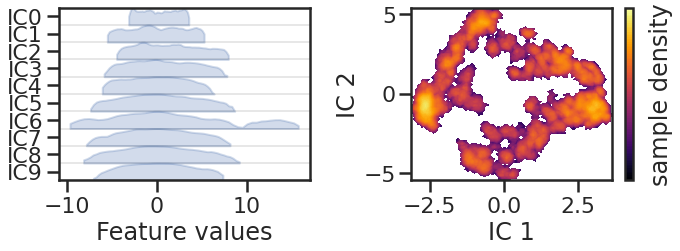

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated[:, :10],
    ax=axes[0],
    feature_labels=['IC' + str(tic) for tic in range(10)],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, vis_tic].T,
                          ax=axes[1],
                          logscale=True,
                          cmap='inferno')
axes[1].set_xlabel(f'IC {vis_tic[0]+1}')
axes[1].set_ylabel(f'IC {vis_tic[1]+1}')
fig.tight_layout()

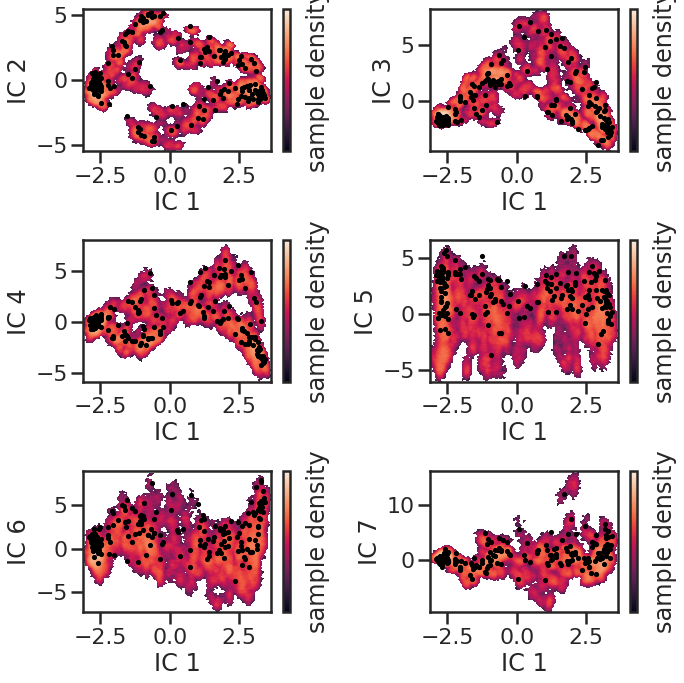

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for tica_ind, ax in zip(range(1,7), axes.flatten()):
    pyemma.plots.plot_density(*tica_concatenated[:, [0,tica_ind]].T, ax=ax, logscale=True)
    
    seed_id = 0
    for seed, tica_seed in enumerate(tica_output):
#        if seed in msm_obj.pathway_seed_start:
        color='black'
        ax.scatter(tica_seed[0, 0], tica_seed[0, tica_ind], color=color, s=10)
#        ax.text(tica_seed[0, 0]-0.2, tica_seed[0, tica_ind]+0.2, msm_obj.pathways[seed_id].split('_')[0], color=color)
        seed_id +=1
            
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC ' + str(tica_ind + 1))
fig.tight_layout()

### Other plots

In [34]:
generate_tica_csv(md_dataframe,
                  msm_obj,
                  sel_tics=[0,1,2,3,4],
                  output='tica_all.csv')

fig = export_plotly_3d(tica_csv='tica_all.csv',
                    output='apo_3d_all.html',
                    title='FES apo')

100%|██████████| 195/195 [07:58<00:00,  2.45s/it]


tica_csv:  tica_all.csv
output:  apo_3d_all.html
Exported apo_3d_all.html


/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pyemma/plots/plots2d.py:251: UserWarning: avoid_zero_counts=True is not an allowed optional parameter and will be ignored
  _warn(


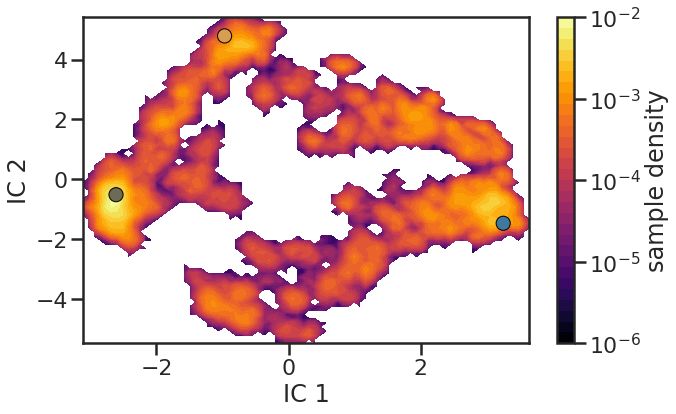

In [32]:
from matplotlib.ticker import LogLocator, MultipleLocator

fig, ax = plt.subplots(figsize=(10, 6))

_, _, misc = pyemma.plots.plot_density(*tica_concatenated[:, vis_tic].T,
                                       ax=ax,
                                       **tica_dens_kwargs
                                       )

ax.set_xlabel(f'IC {vis_tic[0]+1}')
ax.set_ylabel(f'IC {vis_tic[1]+1}')

ax.scatter(x=[state_tica_coord[state]['tica'][0] for state in state_tica_coord],
           y=[state_tica_coord[state]['tica'][1] for state in state_tica_coord],
           marker='o', s=200,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='black', lw=1)

misc['cbar'].set_ticks(LogLocator(base=10.0, numticks=15))

plt.savefig('assets/apo/tica_whole_sys_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

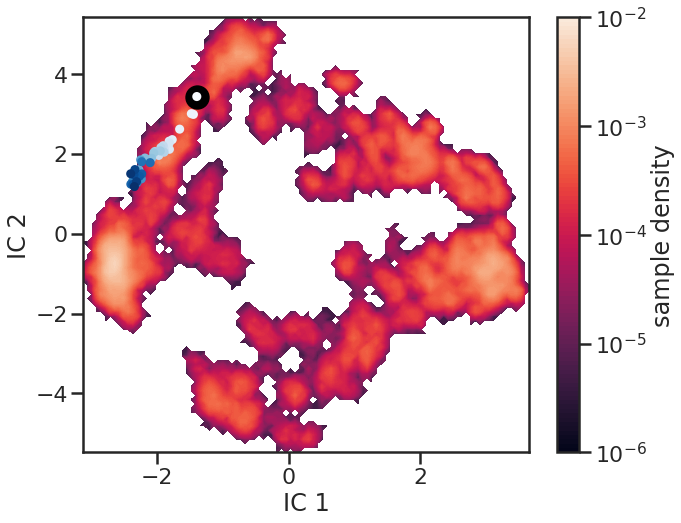

In [33]:
from matplotlib.ticker import LogLocator, MultipleLocator

fig, ax = plt.subplots(figsize=(10, 8))

_, _, misc = pyemma.plots.plot_density(*tica_concatenated[:, vis_tic].T, ax=ax, logscale=True)
ax.scatter(tica_output_7ekt[0][0, vis_tic[0]], tica_output_7ekt[0][0, vis_tic[1]], s=500, c='black')
ax.scatter(tica_output_7ekt[0][:, vis_tic[0]], tica_output_7ekt[0][:, vis_tic[1]], s=50, cmap='Blues', c=range(len(tica_output_7ekt[0])))
ax.set_xlabel(f'IC {vis_tic[0]+1}')
ax.set_ylabel(f'IC {vis_tic[1]+1}')


misc['cbar'].set_ticks(LogLocator(base=10.0, numticks=15))

plt.savefig('assets/apo/7ekt_proj_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

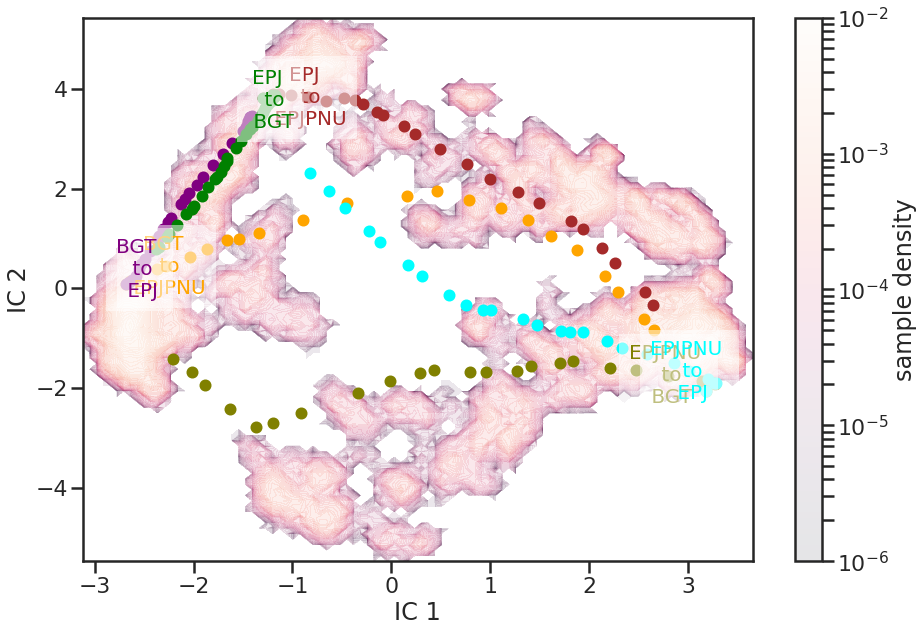

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=ax, logscale=True, alpha=0.1)
colors = ['orange', 'purple', 'brown', 'green', 'olive', 'cyan']

for climber_traj, pathway, color in zip(tica_output_climber, md_climber_dataframe.dataframe['pathway'].unique(), colors):
    ax.scatter(*climber_traj[:, :2].T, s=100, c=color, label=' to '.join(pathway.split('_')))
    ax.text(*climber_traj[4, :2].T, ' \n to\n '.join(pathway.split('_')), color=color, fontsize=20,
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=10.0))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
plt.savefig('assets/apo/tica_climber_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pyemma/plots/plots2d.py:251: UserWarning: avoid_zero_counts=True is not an allowed optional parameter and will be ignored
  _warn(


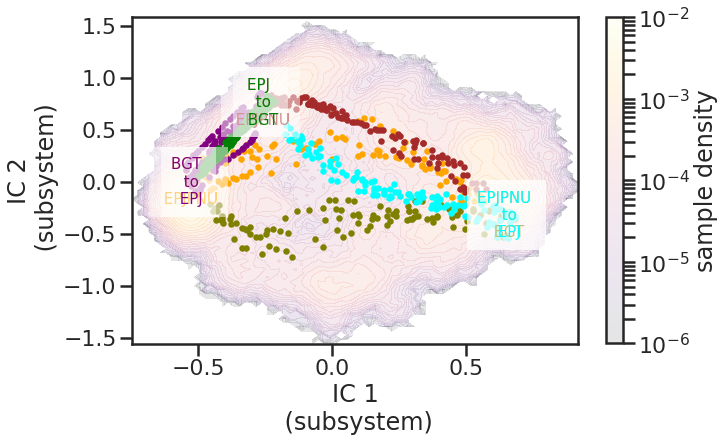

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
tica_subunit_sep_concate = np.concatenate(tica_subunit_concatenated, axis=0)

pyemma.plots.plot_density(
            tica_subunit_sep_concate.T[0],
            tica_subunit_sep_concate.T[1],
            **tica_dens_kwargs,
            alpha=0.1,
            ax=ax)

colors = ['orange', 'purple', 'brown', 'green', 'olive', 'cyan']

for climber_traj, pathway, color in zip(tica_output_subunit_climber, md_climber_dataframe.dataframe['pathway'].unique(), colors):
    ax.scatter(*np.concatenate(climber_traj, axis=0)[:, :2].T,
               s=20, c=color, label=' to '.join(pathway.split('_')))
    ax.text(*np.concatenate(climber_traj, axis=0)[4, :2].T,
            ' \n to\n '.join(pathway.split('_')),
            color=color,
            fontsize=15,
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=10.0))


ax.set_xlabel('IC 1\n (subsystem)')
ax.set_ylabel('IC 2\n (subsystem)')

plt.savefig('assets/apo/tica_climber_sub_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

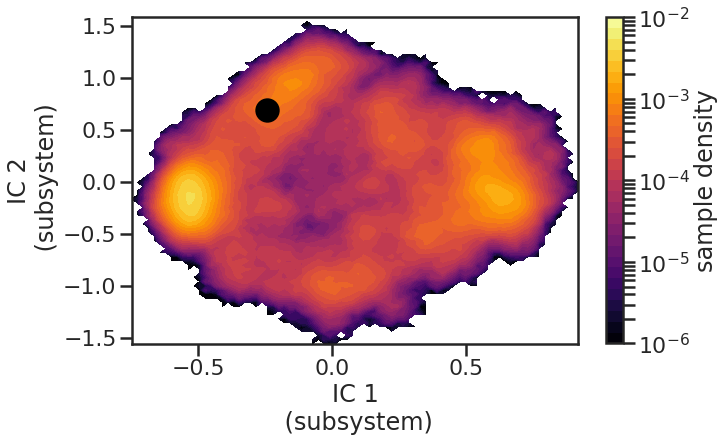

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
tica_subunit_sep_concate = np.concatenate(tica_subunit_concatenated, axis=0)

contourf_kws = dict(locator=ticker.LogLocator(base=10, subs=range(1, 10)))
pyemma.plots.plot_density(
            tica_subunit_sep_concate.T[0],
            tica_subunit_sep_concate.T[1],
            **tica_dens_kwargs,
            ax=ax)

concat_7ekt = np.concatenate(np.concatenate(tica_output_subunit_7ekt),
                             axis=0)
ax.scatter(concat_7ekt[0, 0], concat_7ekt[0, 1],
           s=500, c='black')
#ax.scatter(concat_7ekt[:, 0], concat_7ekt[:, 1],
#           s=5, cmap='Blues', c=range(len(concat_7ekt)))


ax.set_xlabel('IC 1\n (subsystem)')
ax.set_ylabel('IC 2\n (subsystem)')

plt.savefig('assets/apo/tica_7ekt_sub_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

### Microstates

In [16]:
meaningful_tic = [0, 1, 2]

In [17]:
tica_output_filter = [np.asarray(output)[:,meaningful_tic] for output in tica_output]

In [18]:
cross_validation = False
if cross_validation:
    n_clustercenters = [50, 200, 500, 1000, 2000, 4000]

    scores = np.zeros((len(n_clustercenters), 5))
    for n, k in enumerate(n_clustercenters):
        for m in range(5):
            d_cluster = pyemma.coordinates.cluster_kmeans(tica_output_filter,
                                                          k=k,
                                                          max_iter=100,
                                                          stride=100)
            d_cluster_dtrajs = d_cluster.dtrajs
            _msm = pyemma.msm.estimate_markov_model(d_cluster_dtrajs, 100)
            scores[n, m] = _msm.score_cv(
                d_cluster_dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))
#            print(scores[n, m])

In [19]:
if cross_validation:
    fig, ax = plt.subplots()
    lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
    ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
    ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
    ax.semilogx()
    ax.set_xlabel('number of cluster centers')
    ax.set_ylabel('VAMP-2 score')
    fig.tight_layout()

In [24]:
msm_obj.clustering_with_deeptime(meaningful_tic=meaningful_tic,
                   n_clusters=2000)

Meaningful TICs are [0, 1, 2]
Start new cluster analysis


KMeans iterations: 100%|██████████| 61/61 [00:31<00:00,  1.93it/s]  


In [25]:
cluster = msm_obj.cluster
cluster_centers = msm_obj.cluster_centers
cluster_dtrajs = msm_obj.cluster_dtrajs
dtrajs_concatenated = msm_obj.dtrajs_concatenated

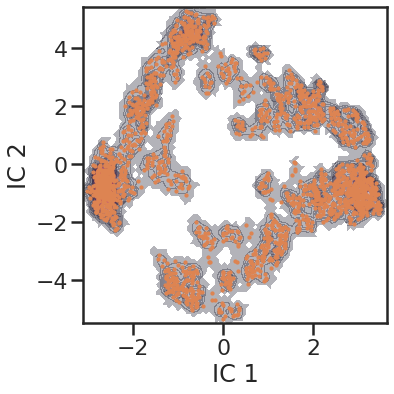

In [26]:
sel_tic = [0, 1]

fig, ax = plt.subplots(figsize=(6, 6))
pyemma.plots.plot_density(
    *tica_concatenated[:, sel_tic].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster_centers[:, sel_tic].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

In [27]:
its = msm_obj.get_its(cluster='deeptime', n_samples=100, n_jobs=10)
msm_obj.plot_its()

Start new ITS analysis


ITS:  10%|█         | 1/10 [02:48<25:16, 168.55s/it]Skipping state set [1631] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [4] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1891] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [418] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [436] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [597] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [617] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [830] due to error in estimation:

RuntimeError: Stationary distribution contains entries smaller than 0.000000 during iteration

In [28]:
msm_model = msm_obj.get_bayesian_msm(lag=200, cluster='deeptime')

print('fraction of states used = {:.4f}'.format(msm_model.prior.state_fraction))
print('fraction of states used = {:.4f}'.format(msm_model.prior.count_fraction))

Start new MSM analysis


RuntimeError: Stationary distribution contains entries smaller than 0.000000 during iteration

In [ ]:
if msm_model.prior.state_fraction != 1.0:
    active_set = msm_model.prior.count_model.states_to_symbols(msm_model.prior.count_model.states)
    inactive_set = list(set(range(msm_model.prior.count_model.n_states_full)).difference(set(active_set)))
    print('Unconnected states:', inactive_set)

    fig, ax = plt.subplots(figsize=(6, 6))

    pyemma.plots.plot_density(
        *tica_concatenated[:, meaningful_tic[:2]].T, ax=ax, cbar=False, alpha=0.3)
    ax.scatter(*cluster_centers[active_set, :2].T, s=5, c='C1')
    ax.scatter(*cluster_centers[inactive_set, :2].T, s=50, c='black')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
    fig.tight_layout()

### Generate figures

In [ ]:
generate_tica_csv(md_dataframe, msm_obj)

fig = export_plotly(tica_csv='tica.csv',
                    output='apo.html',
                    title='FES apo')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    msm_obj.stationary_distribution[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    weights=np.concatenate(msm_obj.trajectory_weights),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic].T, ncontours=30,
    weights=np.concatenate(msm_obj.trajectory_weights),
    ax=ax, cmap='terrain', vmax=14,
    legacy=False)

ymax = 14
fe_plot[2]['cbar'].ax.set_ylim(0,ymax)
fe_plot[2]['cbar'].ax.set_yticks(np.arange(0,ymax,3))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

#ax.invert_yaxis()
#ax.invert_xaxis()

ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
plt.savefig('Figures/a7_apo_new_20230117.png')

In [ ]:
struc_state_dic = {
        'BGT': 'CLOSED',
        'EPJ': 'DESENSITIZED',
        '7ekt': 'I (7EKT)',
        'EPJPNU': 'OPEN',
}

fig, ax = plt.subplots(figsize=(12, 10), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    weights=np.concatenate(msm_obj.trajectory_weights),
    ax=ax, cmap='terrain', vmax=9,
    legacy=False)

fe_plot[2]['cbar'].ax.set_ylim(0,9)
fe_plot[2]['cbar'].ax.set_yticks([0,2,4,6,8])

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
color='black'

#ax.scatter(tica_output_7ekt[0][0, 0], tica_output_7ekt[0][0, 1], s=200, c='Red', marker='*')
#ax.scatter(tica_output_7ekt[0][-1, 0], tica_output_7ekt[0][-1, 1], color=color, s=100, edgecolors='white')

ax.scatter(tica_output_7ekt[0][:, vis_tic[0]],
           tica_output_7ekt[0][:, vis_tic[1]],
           color=color, s=100, edgecolors='white')
ax.text(tica_output_7ekt[0][-1, 0],
        tica_output_7ekt[0][-1, 1],
        struc_state_dic['7ekt'],
        bbox=dict(boxstyle="round",
                ec=(1., 1, 1),
                fc=(1., 1, 1),
                alpha=0.4
                ))

for seed, tica_seed in enumerate(tica_output):
    if seed in start_seed_index[::2]:
#    if seed % 5 == 0:

        color='black'
        ax.scatter(tica_seed[0, vis_tic[0]], tica_seed[0, vis_tic[1]], color=color, s=100, edgecolors='white')
        ax.text(tica_seed[0, vis_tic[0]],
        tica_seed[0, vis_tic[1]],
        struc_state_dic[md_dataframe.dataframe[md_dataframe.dataframe.system==seed // 5].pathway.to_list()[0].split('_')[0]],
        color=color,
        bbox=dict(boxstyle="round",
                ec=(1., 1, 1),
                fc=(1., 1, 1),
                alpha=0.4
                )
        )
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
#plt.savefig('Figures/a7_apo_fe_msm_ca_dist_7ket.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(1,10))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=0, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.terrain,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Free Energy (kT)')
plt.savefig('Figures/msm_cbar.png',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

#### Other plots

In [ ]:
struc_state_dic = {
        'BGT': 'CLOSED',
        'EPJ': 'DESENSITIZED',
        '7ekt': 'I (7EKT)',
        'EPJPNU': 'OPEN',
}

fig, ax = plt.subplots(figsize=(12, 10), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, cmap='terrain', vmax=10,
    legacy=False)

fe_plot[2]['cbar'].ax.set_ylim(0,10)
fe_plot[2]['cbar'].ax.set_yticks([0,2,4,6,8,10])
color='black'

for seed, tica_seed in enumerate(tica_output):
    if seed in start_seed_index[::2]:
#    if seed % 5 == 0:

        color='black'
#        ax.scatter(tica_seed[0, vis_tic[0]], tica_seed[0, vis_tic[1]], color=color, s=100, edgecolors='white')
        ax.text(tica_seed[0, vis_tic[0]],
        tica_seed[0, vis_tic[1]],
        struc_state_dic[md_dataframe.dataframe[md_dataframe.dataframe.system==seed // 5].pathway.to_list()[0].split('_')[0]],
        color=color,
        bbox=dict(boxstyle="round",
                ec=(1., 1, 1),
                fc=(1., 1, 1),
                alpha=0.4
                )
        )

ax.scatter(tica_output_df[0][:, 0], tica_output_df[0][:, 1], s=5, cmap="Blues", c=range(tica_output_df[0][:, 0].shape[0]))
ax.scatter(tica_output_df[9][:, 0], tica_output_df[9][:, 1], s=5, cmap="Purples", c=range(tica_output_df[9][:, 0].shape[0]))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
plt.savefig('Figures/a7_fe_msm_ca_dist_dens.png',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [ ]:
struc_state_dic = {
        'BGT': 'CLOSED',
        'EPJ': 'DESENSITIZED',
        '7ekt': 'I (7EKT)',
        'EPJPNU': 'OPEN',
}

fig, ax = plt.subplots(figsize=(12, 10), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, cmap='terrain', vmax=10,
    legacy=False)

fe_plot[2]['cbar'].ax.set_ylim(0,10)
fe_plot[2]['cbar'].ax.set_yticks([0,2,4,6,8,10])
color='black'

for seed, tica_seed in enumerate(tica_output):
    if seed in start_seed_index[::2]:
#    if seed % 5 == 0:

        color='black'
#        ax.scatter(tica_seed[0, vis_tic[0]], tica_seed[0, vis_tic[1]], color=color, s=100, edgecolors='white')
        ax.text(tica_seed[0, vis_tic[0]],
        tica_seed[0, vis_tic[1]],
        struc_state_dic[md_dataframe.dataframe[md_dataframe.dataframe.system==seed // 5].pathway.to_list()[0].split('_')[0]],
        color=color,
        bbox=dict(boxstyle="round",
                ec=(1., 1, 1),
                fc=(1., 1, 1),
                alpha=0.4
                )
        )

ax.scatter(tica_output_df[0][:, 0], tica_output_df[0][:, 1], s=10, cmap="Reds", c=range(tica_output_df[0][:, 0].shape[0]))
ax.scatter(tica_output_df[9][:, 0], tica_output_df[9][:, 1], s=10, cmap="Oranges", c=range(tica_output_df[9][:, 0].shape[0]))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
plt.savefig('Figures/a7_fe_msm_ca_dist_dens_new.png', api=600, bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [ ]:
struc_state_dic = {
        'BGT': 'CLOSED',
        'EPJ': 'DESENSITIZED',
        '7ekt': 'I (7EKT)',
        'EPJPNU': 'OPEN',
}

fig, ax = plt.subplots(figsize=(12, 10), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic].T,
    weights=np.concatenate(msm_obj.trajectory_weights),
    ax=ax, cmap='terrain', vmax=10,
    legacy=False)

fe_plot[2]['cbar'].ax.set_ylim(0,10)
fe_plot[2]['cbar'].ax.set_yticks([0,2,4,6,8,10])
color='black'

for seed, tica_seed in enumerate(tica_output):
    if seed in start_seed_index[::2]:
#    if seed % 5 == 0:

        color='black'
#        ax.scatter(tica_seed[0, vis_tic[0]], tica_seed[0, vis_tic[1]], color=color, s=100, edgecolors='white')
        ax.text(tica_seed[0, vis_tic[0]],
        tica_seed[0, vis_tic[1]],
        struc_state_dic[md_dataframe.dataframe[md_dataframe.dataframe.system==seed // 5].pathway.to_list()[0].split('_')[0]],
        color=color,
        bbox=dict(boxstyle="round",
                ec=(1., 1, 1),
                fc=(1., 1, 1),
                alpha=0.4
                )
        )

for output in tica_output_climber[::5]:
        ax.scatter(output[:, 0], output[:, 1], s=50)

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
plt.savefig('Figures/a7_fe_msm_ca_dist_climber_100.png',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

## CK test

In [ ]:
n_states = 5

In [ ]:
ck_grid = msm_obj.get_ck_test(n_states=n_states, lag=50)

In [ ]:
msm_obj.pcca = msm_model.prior.pcca(n_states)

In [ ]:
fig, axes = plt.subplots(1, n_states, figsize=(5*n_states, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, meaningful_tic[:2]].T,
        msm_obj.pcca.memberships.T[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='Prob. of PCCA state {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
metastable_traj = [msm_obj.pcca.assignments[c_traj] for c_traj in cluster_dtrajs]
metastable_concat = np.concatenate(metastable_traj)

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    metastable_concat, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(n_states)])
fig.tight_layout()

In [ ]:
state_labels= dict(zip(range(n_states), ['D', 'I2', 'I1', 'O', 'C']))

In [ ]:
metastable_traj = [msm_obj.pcca.assignments[c_traj] for c_traj in cluster_dtrajs]
metastable_concat = np.concatenate(metastable_traj)

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    metastable_concat, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([state_labels[i]
                             for i in range(n_states)])
fig.tight_layout()

In [ ]:
print('label\tstate\tπ\t\tG/kT')
for i, s in enumerate(msm_obj.pcca.sets):
    p = msm_obj.stationary_distribution[s].sum()
    print('{}\t{}\t{:f}\t{:f}'.format(state_labels[i], i + 1, p, -np.log(p)))

In [ ]:
from itertools import product

mfpt = np.zeros((n_states, n_states))
mfpt_std = np.zeros((n_states, n_states))

for i, j in product(range(n_states), repeat=2):
    stats_mfpt = msm_model.gather_stats("mfpt",
                                        A=msm_obj.pcca.sets[i],
                                        B=msm_obj.pcca.sets[j])
    mfpt[i, j] = stats_mfpt.mean * msm_obj.dt

    mfpt_std[i, j] = stats_mfpt.std * msm_obj.dt

In [ ]:
print('MFPT / us:')
DataFrame(np.round(mfpt / 1000, decimals=2),
            index=[state_labels[i] + ' to'
                             for i in range(n_states)],
            columns=[state_labels[i]
                             for i in range(n_states)])

In [ ]:
print('MFPT STD / us:')

DataFrame(np.round(mfpt_std / 1000, decimals=2),
            index=[state_labels[i] + ' to'
                             for i in range(n_states)],
            columns=[state_labels[i]
                             for i in range(n_states)])

In [ ]:
stat_1 = 4
stat_2 = 3
fig, axes = plt.subplots(1,2,figsize=(15, 7))

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_1],
                                             msm_obj.pcca.sets[stat_2])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                          commitor[dtrajs_concatenated],
                          ax=axes[0],
                          mask=True,
                          cmap='plasma')
axes[0].set_xlabel('TIC 1')
axes[0].set_ylabel('TIC 2')
axes[0].set_title(f'Committor from {state_labels[stat_1]} to {state_labels[stat_2]}', fontweight='bold')

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_2],
                                             msm_obj.pcca.sets[stat_1])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                                commitor[dtrajs_concatenated],
                                ax=axes[1],
                                mask=True,
                                cmap='plasma',
                                )
axes[1].set_xlabel('TIC 1')
axes[1].set_ylabel('TIC 2')
axes[1].set_title(f'Committor from {state_labels[stat_2]} to {state_labels[stat_1]}', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
stat_1 = 0
stat_2 = 4
fig, axes = plt.subplots(1,2,figsize=(15, 7))

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_1],
                                             msm_obj.pcca.sets[stat_2])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                          commitor[dtrajs_concatenated],
                          ax=axes[0],
                          mask=True,
                          cmap='plasma')
axes[0].set_xlabel('TIC 1')
axes[0].set_ylabel('TIC 2')
axes[0].set_title(f'Committor from {state_labels[stat_1]} to {state_labels[stat_2]}', fontweight='bold')

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_2],
                                             msm_obj.pcca.sets[stat_1])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                                commitor[dtrajs_concatenated],
                                ax=axes[1],
                                mask=True,
                                cmap='plasma',
                                )
axes[1].set_xlabel('TIC 1')
axes[1].set_ylabel('TIC 2')
axes[1].set_title(f'Committor from {state_labels[stat_2]} to {state_labels[stat_1]}', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
stat_1 = 0
stat_2 = 3
fig, axes = plt.subplots(1,2,figsize=(15, 7))

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_1],
                                             msm_obj.pcca.sets[stat_2])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                          commitor[dtrajs_concatenated],
                          ax=axes[0],
                          mask=True,
                          cmap='plasma')
axes[0].set_xlabel('TIC 1')
axes[0].set_ylabel('TIC 2')
axes[0].set_title(f'Committor from {state_labels[stat_1]} to {state_labels[stat_2]}', fontweight='bold')

commitor = msm_model.prior.committor_forward(msm_obj.pcca.sets[stat_2],
                                             msm_obj.pcca.sets[stat_1])
pyemma.plots.plot_contour(*tica_concatenated[:, meaningful_tic].T,
                                commitor[dtrajs_concatenated],
                                ax=axes[1],
                                mask=True,
                                cmap='plasma',
                                )
axes[1].set_xlabel('TIC 1')
axes[1].set_ylabel('TIC 2')
axes[1].set_title(f'Committor from {state_labels[stat_2]} to {state_labels[stat_1]}', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [ ]:
highest_membership = msm_obj.pcca.metastable_distributions.argmax(1)
coarse_state_centers = cluster_centers[highest_membership]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    metastable_concat,
    ax=ax, zorder=-1, cmap='Pastel2')

misc['cbar'].set_ticklabels(range(1, n_states + 1))

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.0f us',
    arrow_labels= mfpt / 1000,
    size=16,
    show_frame=True,
    state_labels=[state_labels[i] for i in range(n_states)],
    ax=ax)
ax.set_xlim(-2,2)
ax.set_ylim(-3,3)
fig.tight_layout()
#plt.savefig('Figures/a7_fe_msm_kinetic.png')

# Show correlation

In [14]:
if True:    
    test_feature_TIC_correlation_df = msm_obj.get_correlation('ca_distance_10A_2diff')

100%|██████████| 3920/3920 [00:55<00:00, 70.29it/s] 


In [15]:
test_feature_TIC_correlation_df

,TIC1,TIC2,TIC3
ca_distance_10A_2diff_A_1_E_18,-0.017081,-0.161065,0.101221
ca_distance_10A_2diff_A_1_E_19,-0.027418,-0.106569,0.057896
ca_distance_10A_2diff_A_1_E_20,-0.017988,-0.001534,0.033479
ca_distance_10A_2diff_A_4_E_18,-0.031684,-0.033530,0.045511
ca_distance_10A_2diff_A_5_A_71,-0.036724,-0.020997,0.064945
...,...,...,...
ca_distance_10A_2diff_J_391_J_394,0.243946,0.548151,0.046287
ca_distance_10A_2diff_J_391_J_396,-0.485856,-0.355556,-0.026972
ca_distance_10A_2diff_J_396_J_400,0.189666,0.318133,-0.040130
ca_distance_10A_2diff_J_396_J_401,0.148344,0.406747,-0.043581


In [23]:
for row in test_feature_TIC_correlation_df.itertuples():
    for resid in resids_exclusion:
        if resid == eval(row.Index[22:].split('_')[1]) or resid == eval(row.Index[22:].split('_')[3]):
            # remove the row
            test_feature_TIC_correlation_df.drop(row.Index, inplace=True)
            break

In [28]:
test_feature_TIC_correlation_df['singular_vec_left_eig_0'] = np.concatenate([tica_model_tica.singular_vectors_left.T[0] for _ in range(5)], axis=0)
test_feature_TIC_correlation_df['singular_vec_left_eig_1'] = np.concatenate([tica_model_tica.singular_vectors_left.T[1] for _ in range(5)], axis=0)
test_feature_TIC_correlation_df['singular_vec_left_eig_2'] = np.concatenate([tica_model_tica.singular_vectors_left.T[2] for _ in range(5)], axis=0)

In [29]:
#test_feature_TIC_correlation_df = test_feature_TIC_correlation_df.reindex(test_feature_TIC_correlation_df.TIC1.abs().sort_values().index)[::-1]
test_feature_TIC_correlation_df = test_feature_TIC_correlation_df.reindex(test_feature_TIC_correlation_df.singular_vec_left_eig_0.sort_values().index)[::-1]

In [30]:
feat_all = md_dataframe.get_feature([
                                    'ca_distance_10A_2diff'
                                    ],
                        extra_metadata=['seed', 'pathway', 'ensemble'])

# recipropcal to distance
#feat_all.iloc[:, 7:] = feat_all.iloc[:, 7:].apply(lambda x: 1 / x)

Loading features: 100%|██████████| 1/1 [00:38<00:00, 38.20s/it]


In [31]:
feat_index = test_feature_TIC_correlation_df.index.to_list()

In [ ]:
msm_

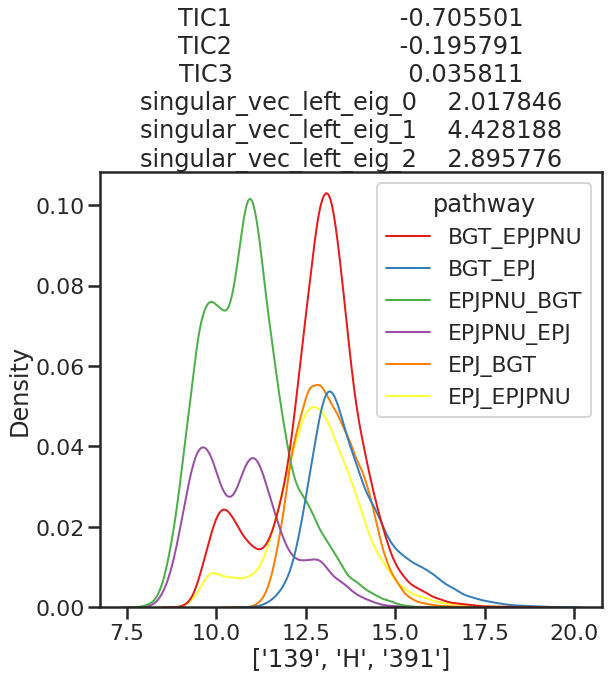

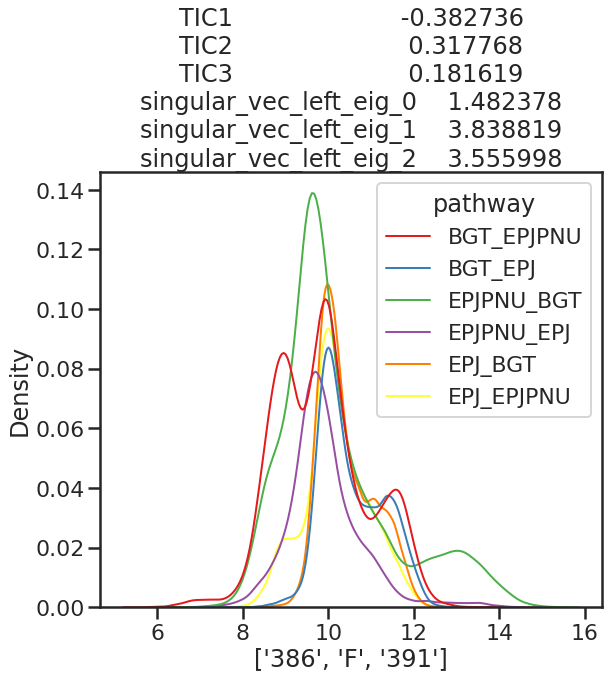

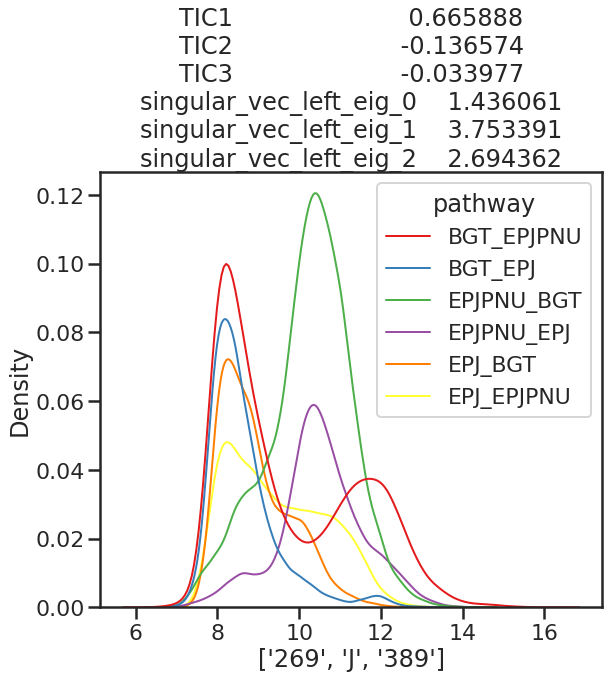

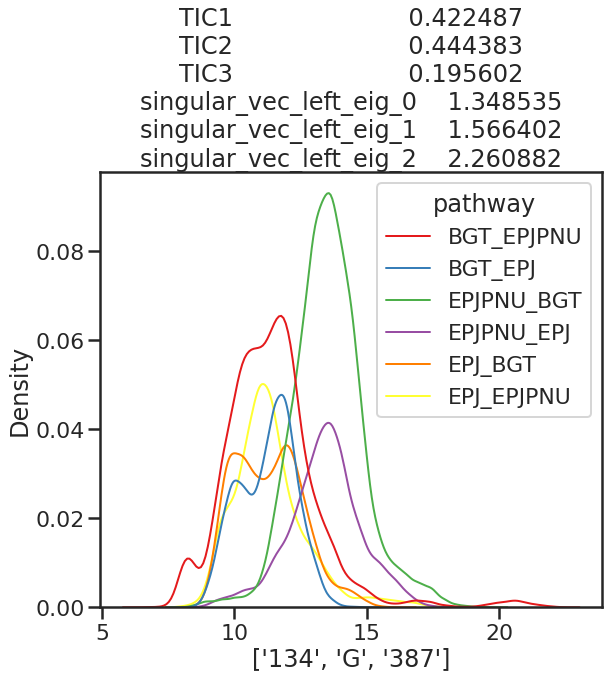

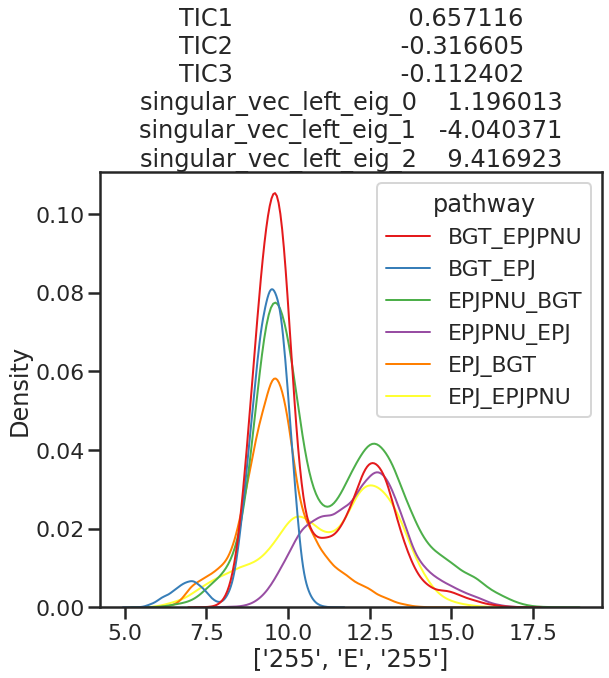

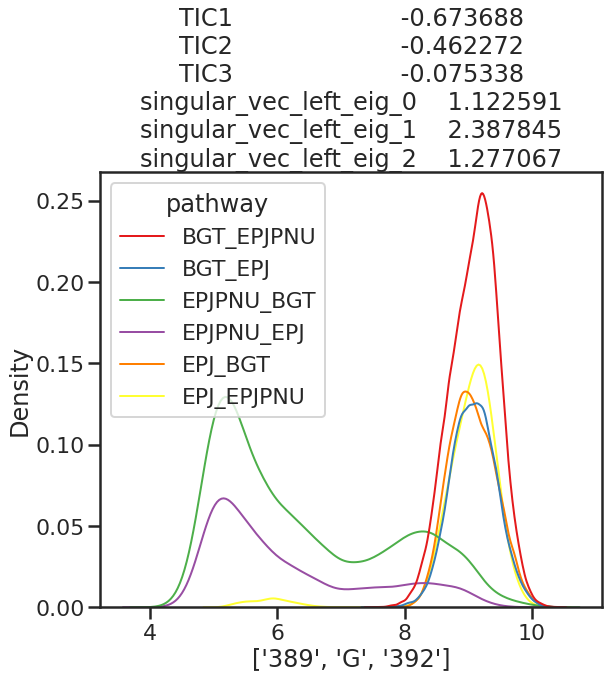

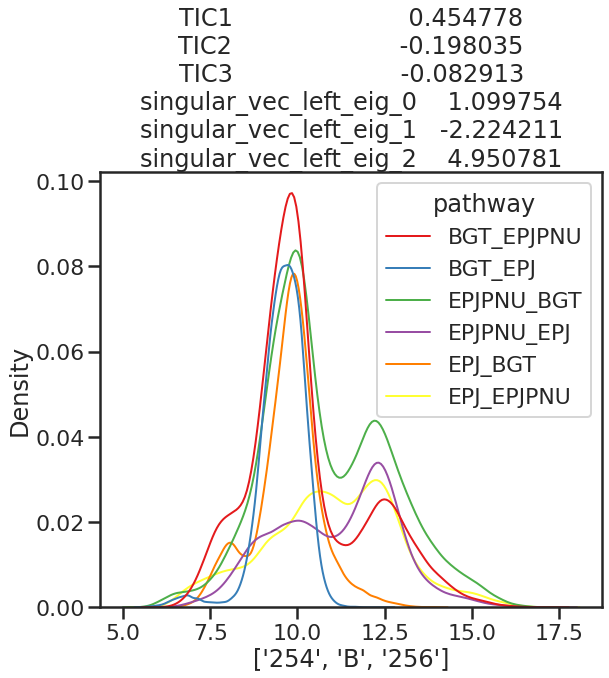

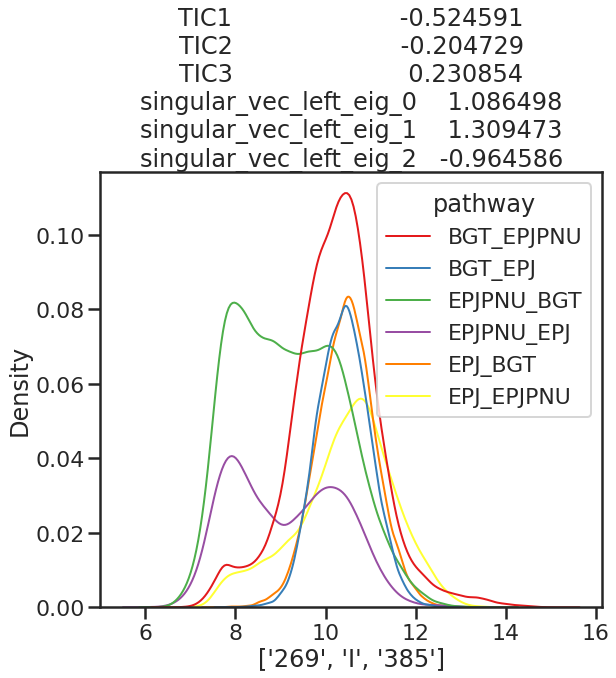

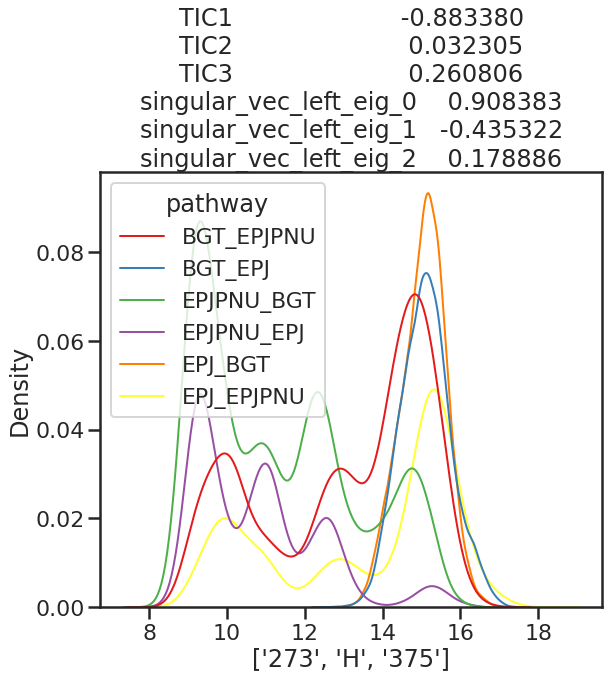

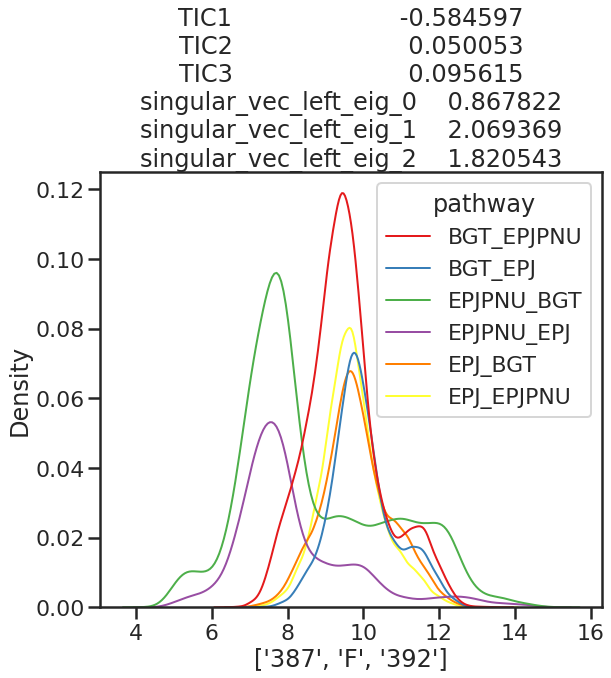

In [33]:
for feat in feat_index[:50:5]:
    fig, ax = plt.subplots(1, 1, figsize=(9, 8))
    ax = sns.kdeplot(data=feat_all, hue='pathway',
                x=feat, ax=ax, linewidth=2, legend=True, palette='Set1')
#    ax.legend(labels=feat_all.name.unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    x_lab = ax.get_xlabel()
    ax.set_xlabel(x_lab.split('_')[4:])
    ax.set_title(test_feature_TIC_correlation_df.T[feat].to_string().split('/n')[0])
    plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
feat = 'ca_distance_10A_2diff_logminmax5_A_1_E_18'
sns.kdeplot(data=feat_all,
            x=feat, ax=ax, linewidth=2, legend=True, palette='Set1')
feat = 'ca_distance_10A_2diff_logminmax2_A_1_E_18'
sns.kdeplot(data=feat_all,
            x=feat, ax=ax, linewidth=2, legend=True, palette='Set1')
#    ax.legend(labels=feat_all.name.unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

x_lab = ax.get_xlabel()
ax.set_xlabel(x_lab.split('_')[5:])
#ax.set_title(test_feature_TIC_correlation_df.T[feat].to_string().split('/n')[0])
plt.show()

In [ ]:
feat = 'ca_distance_10A_2diff_logminmax5_D_270_I_390'

plt.scatter(np.arange(feat_all[feat].shape[0]), feat_all[feat].sort_values(),
            label='logminmax5')

feat = 'ca_distance_10A_2diff_logminmax2_D_270_I_390'

plt.scatter(np.arange(feat_all[feat].shape[0]), feat_all[feat].sort_values(),
            label='logminmax2')
plt.legend()

In [37]:
feat_all.query('system in [23, 48]')

,system,traj_name,frame,traj_time,seed,pathway,ensemble,ca_distance_10A_2diff_A_1_E_18,ca_distance_10A_2diff_A_1_E_19,ca_distance_10A_2diff_A_1_E_20,...,ca_distance_10A_2diff_J_388_J_392,ca_distance_10A_2diff_J_388_J_393,ca_distance_10A_2diff_J_389_J_392,ca_distance_10A_2diff_J_390_J_393,ca_distance_10A_2diff_J_390_J_394,ca_distance_10A_2diff_J_391_J_394,ca_distance_10A_2diff_J_391_J_396,ca_distance_10A_2diff_J_396_J_400,ca_distance_10A_2diff_J_396_J_401,ca_distance_10A_2diff_J_397_J_400
25857,23,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,0,0.0,23,BGT_EPJPNU,PRODUCTION,7.998621,9.305889,8.288174,...,8.001560,7.837589,8.065099,6.176520,9.827440,9.189495,7.991157,6.100817,8.333359,4.869806
25858,23,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,2,1000.0,23,BGT_EPJPNU,PRODUCTION,8.034080,9.159187,8.243535,...,8.320531,8.982370,8.081513,6.425172,9.787367,9.124155,8.544882,6.376994,8.792891,4.856126
25859,23,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,4,2000.0,23,BGT_EPJPNU,PRODUCTION,8.256218,9.932689,9.523714,...,7.919989,8.224541,7.899453,5.394265,8.839396,9.136438,8.474496,6.005547,8.280855,5.001968
25860,23,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,6,3000.0,23,BGT_EPJPNU,PRODUCTION,7.893702,9.145078,9.065602,...,8.298653,8.225667,8.442354,6.383957,9.962138,9.217949,8.585819,6.167945,8.420577,4.937550
25861,23,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,8,4000.0,23,BGT_EPJPNU,PRODUCTION,7.906578,9.761933,9.255462,...,9.326180,9.332359,8.633663,6.225637,9.528764,9.066701,8.425059,6.410562,8.853298,4.903062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54101,48,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,2218,1109000.0,0,EPJPNU_BGT,PRODUCTION,12.418609,12.209593,11.804748,...,6.812892,7.976079,4.936859,8.407976,10.958926,9.346038,7.627689,6.683518,8.725677,5.344874
54102,48,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,2220,1110000.0,0,EPJPNU_BGT,PRODUCTION,9.015777,9.538406,10.068796,...,7.380974,7.893607,5.459943,8.415695,11.221969,9.253981,7.914868,6.421194,8.691182,5.229955
54103,48,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,2222,1111000.0,0,EPJPNU_BGT,PRODUCTION,9.496456,9.642254,9.738604,...,7.325983,8.302941,4.976796,8.188492,10.446871,8.988580,8.024627,5.952553,8.508917,5.012681
54104,48,/mnt/cephfs/projects/2021072000_nachrs_a7_msm/...,2224,1112000.0,0,EPJPNU_BGT,PRODUCTION,9.991857,10.434053,11.004297,...,7.203138,8.204751,5.137023,8.258460,10.738962,9.123235,7.615215,6.540474,8.466126,5.229621


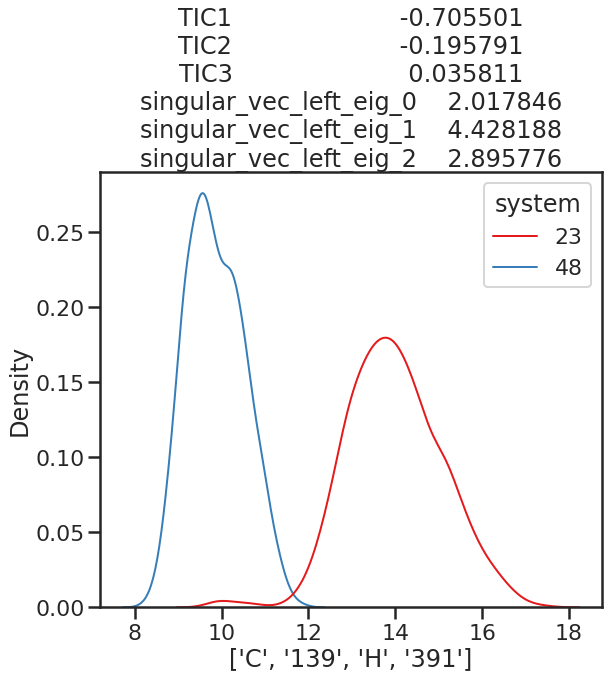

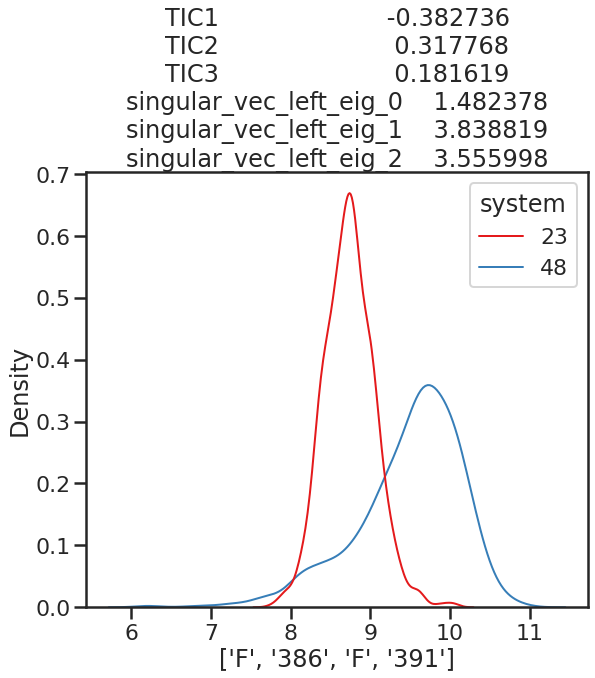

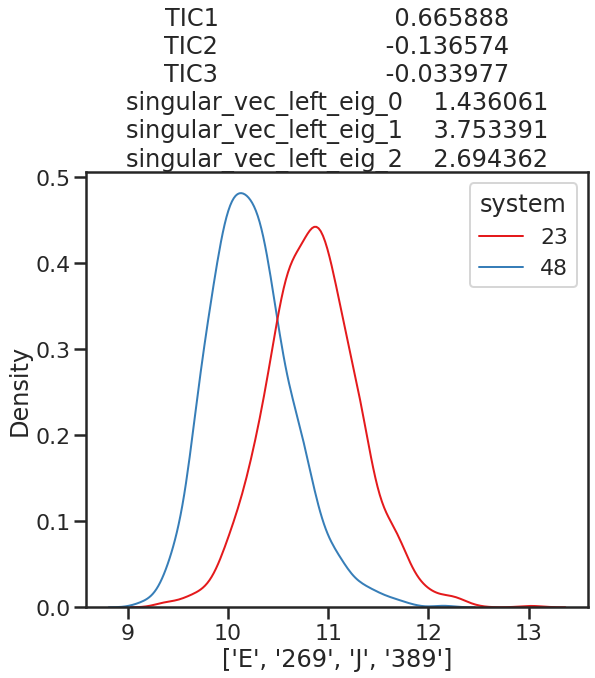

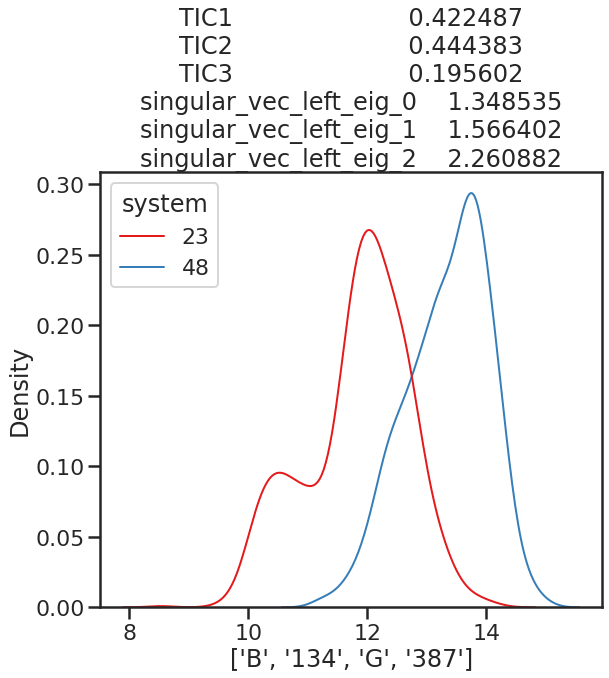

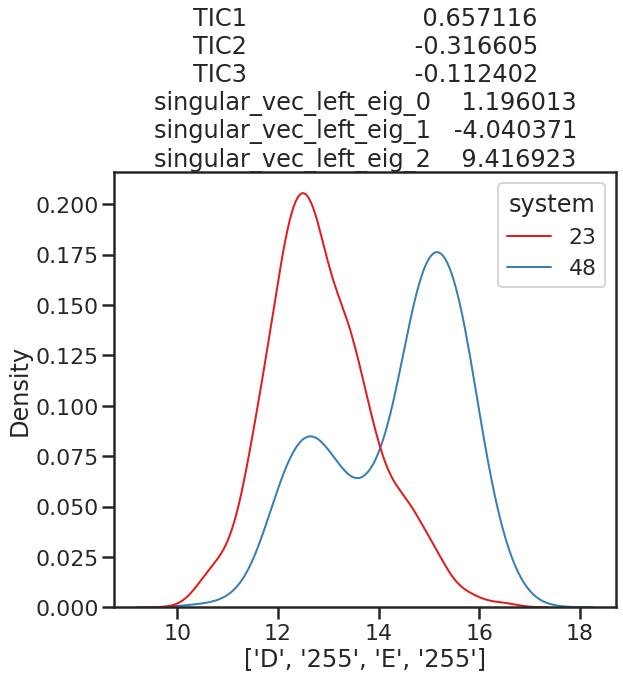

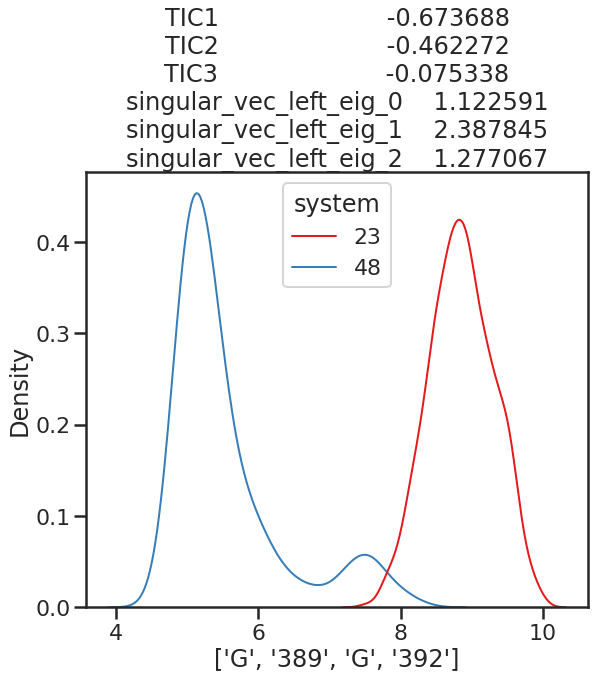

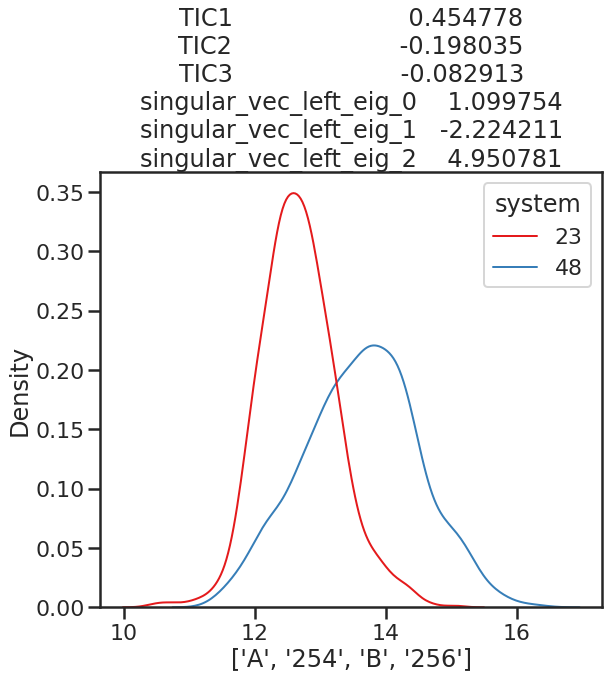

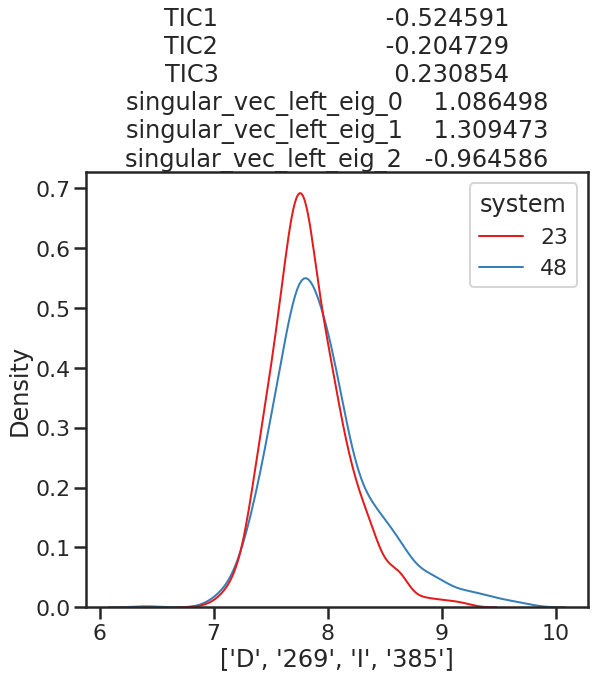

In [38]:
for feat in feat_index[:40:5]:
    fig, ax = plt.subplots(1, 1, figsize=(9, 8))
    ax = sns.kdeplot(data=feat_all.query('system in [23, 48]'),
                x=feat, ax=ax, hue='system', linewidth=2, legend=True, palette='Set1')
#    ax.legend(labels=feat_all.name.unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    x_lab = ax.get_xlabel()
    ax.set_xlabel(x_lab.split('_')[4:])
    ax.set_title(test_feature_TIC_correlation_df.T[feat].to_string().split('/n')[0])
    plt.show()

In [23]:
traj_23 = msm_obj.feature_trajectories[23]
traj_48 = msm_obj.feature_trajectories[48]

In [25]:
tica_sub_23 = tica_model_tica.transform_subunit(traj_23)
tica_sub_48 = tica_model_tica.transform_subunit(traj_48)

In [26]:
tica_23 = tica_model_tica.transform(traj_23)
tica_48 = tica_model_tica.transform(traj_48)

<AxesSubplot: >

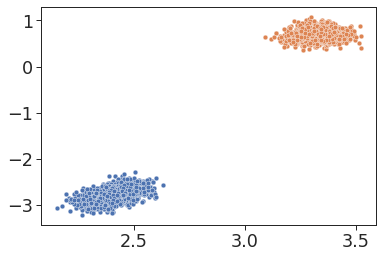

In [29]:
sns.scatterplot(x=tica_23[:, 0], y=tica_23[:, 1])
sns.scatterplot(x=tica_48[:, 0], y=tica_48[:, 1])

<AxesSubplot: >

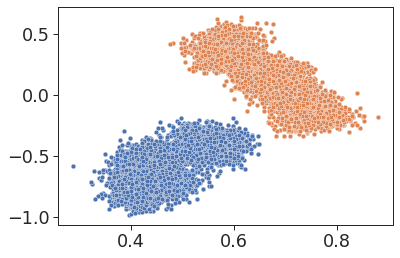

In [32]:
sns.scatterplot(x=np.concatenate(tica_sub_23, axis=0)[:, 0],
                y=np.concatenate(tica_sub_23, axis=0)[:, 1])
sns.scatterplot(x=np.concatenate(tica_sub_48, axis=0)[:, 0],
                y=np.concatenate(tica_sub_48, axis=0)[:, 1])

In [72]:
diff_23_48_tic_1 = []
diff_23_48_tic_2 = []

for n_feat in range(tica_model_tica.mean_0.shape[0]):
    x_23 = traj_23.reshape(-1, 5, 617) - tica_model_tica.mean_0
    x_sub_tic1_23 = x_23[0, :, n_feat:n_feat+1] @ tica_model_tica.singular_vectors_left[n_feat:n_feat+1, 0]
    x_48 = traj_48.reshape(-1, 5, 617) - tica_model_tica.mean_0
    x_sub_tic1_48 = x_48[0, :, n_feat:n_feat+1] @ tica_model_tica.singular_vectors_left[n_feat:n_feat+1, 0]
    diff_23_48_tic_1.append(np.sum(x_sub_tic1_23 - x_sub_tic1_48))
    x_sub_tic2_23 = x_23[0, :, n_feat:n_feat+1] @ tica_model_tica.singular_vectors_left[n_feat:n_feat+1, 1]
    x_sub_tic2_48 = x_48[0, :, n_feat:n_feat+1] @ tica_model_tica.singular_vectors_left[n_feat:n_feat+1, 1]
    diff_23_48_tic_2.append(np.sum(x_sub_tic2_23 - x_sub_tic2_48))

diff_23_48_tic_1 = np.array(diff_23_48_tic_1)
diff_23_48_tic_2 = np.array(diff_23_48_tic_2)

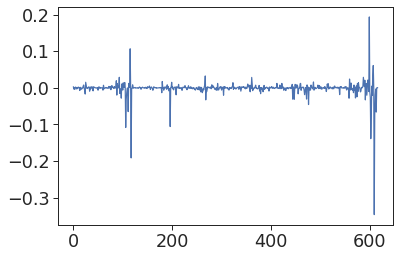

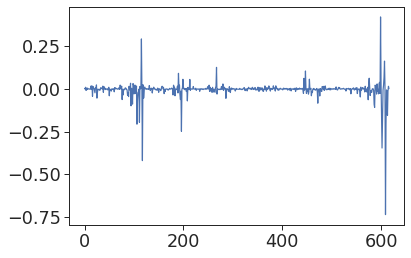

In [79]:
plt.plot(diff_23_48_tic_1)
plt.show()
plt.plot(diff_23_48_tic_2)
plt.show()

In [99]:
diff_decay_tic1 = []
diff_decay_tic2 = []

for start_ind in range(500):
    diff_decay_tic1.append(np.sum(diff_23_48_tic_1[np.abs(diff_23_48_tic_1).argsort()[::-1]][start_ind:]))
    diff_decay_tic2.append(np.sum(diff_23_48_tic_2[np.abs(diff_23_48_tic_2).argsort()[::-1]][start_ind:]))

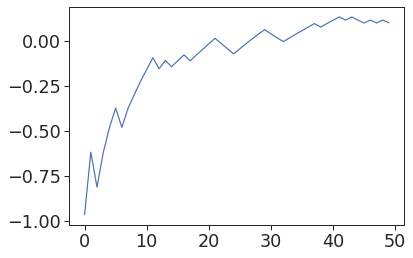

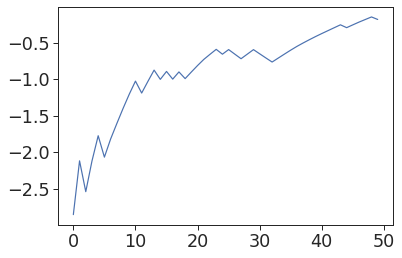

In [103]:
plt.plot(diff_decay_tic1[:50])
plt.show()
plt.plot(diff_decay_tic2[:50])
plt.show()

In [97]:
feat_used = feat_info[feat_ind_inclusion]

In [109]:
residue_diff = []
for feat in feat_used[np.abs(diff_23_48_tic_1).argsort()[::-1]][:30]:
    residue_diff.append(eval(feat.split('_')[1]))
    residue_diff.append(eval(feat.split('_')[3]))

for feat in feat_used[np.abs(diff_23_48_tic_2).argsort()[::-1]][:30]:
    residue_diff.append(eval(feat.split('_')[1]))
    residue_diff.append(eval(feat.split('_')[3]))    

In [111]:
set(residue_diff)

{56,
 118,
 134,
 135,
 136,
 137,
 138,
 139,
 190,
 204,
 208,
 232,
 235,
 236,
 245,
 254,
 255,
 256,
 257,
 269,
 270,
 271,
 277,
 291,
 292,
 293,
 294,
 295,
 296,
 364,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396}